In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers

2024-07-21 09:33:20.801496: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-21 09:33:20.837893: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-21 09:33:21.362493: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Coletando dados

df = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/RJ_Reconstrucao_Crustaceos_2024_06_25.xlsx')

df_Camaroes = df[['Ano', 'Cam_branco_art', 'Cam_rosa_art', 'Cam_barba_ruca_art','Cam_santana_art']].dropna().reset_index(drop=True)


dados = df_Camaroes[['Ano','Cam_branco_art']]
for i in range(len(dados['Ano'])):
  dados.loc[i,'Soma'] = df_Camaroes.loc[i,'Cam_branco_art']+df_Camaroes.loc[i,'Cam_rosa_art']+df_Camaroes.loc[i, 'Cam_barba_ruca_art']+df_Camaroes.loc[i,'Cam_santana_art']
  
dados = dados[['Ano','Cam_branco_art','Soma']]

#Fazendo as proporções
for i in range(len(dados['Ano'])):
  dados.loc[i,'Prop_Cam_branco_art'] = dados.loc[i,'Cam_branco_art'] / dados.loc[i,'Soma']


anos_com_dados = dados["Ano"].values
anos_para_prever = np.array([1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022])
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()

prop = dados['Prop_Cam_branco_art'].values
dados.head()

/tmp/ipykernel_56461/3742151313.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados.loc[i,'Soma'] = df_Camaroes.loc[i,'Cam_branco_art']+df_Camaroes.loc[i,'Cam_rosa_art']+df_Camaroes.loc[i, 'Cam_barba_ruca_art']+df_Camaroes.loc[i,'Cam_santana_art']


,Ano,Cam_branco_art,Soma,Prop_Cam_branco_art
0,1989,174.0,5039.0,0.034531
1,1996,94.0,316.0,0.297468
2,1997,88.5,792.0,0.111742
3,1998,174.5,505.5,0.345203
4,1999,98.5,467.0,0.210921


In [3]:
#Normalização dos dados

ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)
anos_para_prever_norm = (anos_para_prever - ano_mean)/ano_std
anos_com_dados_norm = (anos_com_dados - ano_mean)/ano_std

prop_mean = np.mean(prop)
prop_std = np.std(prop)
prop_norm = (prop - prop_mean)/prop_std

In [4]:
#Fit do modelo e salvando seus pesos
model = keras.Sequential([layers.Dense(96,activation='leaky_relu',input_shape=(1,)),
                             layers.Dense(32,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(96,activation='leaky_relu'),
                             layers.Dense(112,activation='leaky_relu'),
                             layers.Dense(1,activation='linear')])

opt = keras.optimizers.Nadam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')


#history = model.fit(anos_com_dados_norm,prop_norm, epochs=500, verbose=1)
#model.save_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Cam_branco/pesos prop art 1989-2022/.weights.h5', overwrite=True)

/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
model.load_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Cam_branco/pesos prop art 1989-2022/.weights.h5')

/home/andre/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 31 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Previsões dos dados ausentes: [[0.03864321]
 [0.06818815]
 [0.0977616 ]
 [0.12726055]
 [0.1567252 ]
 [0.18690658]
 [0.21759288]
 [0.24228045]
 [0.24609506]
 [0.26512155]
 [0.23409733]
 [0.21091402]
 [0.21372914]
 [0.21401699]
 [0.20677304]
 [0.19962037]
 [0.19877611]
 [0.20023865]
 [0.14049645]
 [0.06062774]
 [0.61307454]
 [0.5794729 ]
 [0.49329862]
 [0.40375113]
 [0.31341764]
 [0.22271335]
 [0.13274561]
 [0.28404015]
 [0.4309941 ]
 [0.5413984 ]
 [0.6518025 ]
 [0.7622464 ]
 [0.8736476 ]
 [0.982582  ]]


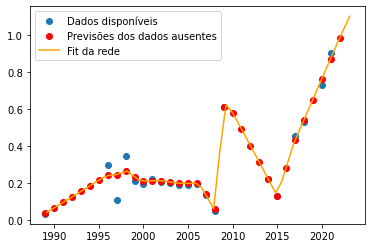

In [6]:
#Previsões
prev_disponiveis = model.predict(anos_com_dados_norm)*prop_std + prop_mean
prev_ausentes = model.predict(anos_para_prever_norm)*prop_std + prop_mean

#Colocando valores negativos para 0
for i in range(len(prev_ausentes)):
    if prev_ausentes[i]<0:
        prev_ausentes[i]=0
    if prev_ausentes[i]>=1:
        prev_ausentes[i]=1

#Plot dos dados e previsões
f1=plt.figure(1).add_subplot()
f1.scatter(anos_com_dados,prop,label='Dados disponíveis')
f1.scatter(anos_para_prever,prev_ausentes, color='red', label='Previsões dos dados ausentes')

#Plot do fit da rede
p = np.linspace(-2,2,50)
y = model.predict(p)*prop_std + prop_mean
f1.plot(p*ano_std + ano_mean,y,color='orange',label='Fit da rede')

#Print das previsões
print('Previsões dos dados ausentes:', prev_ausentes)


plt.legend()
plt.show()

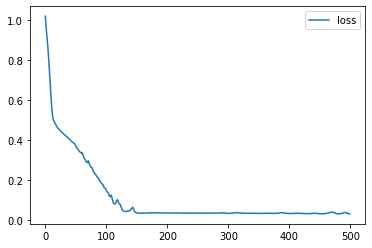

In [9]:
loss = history.history['loss']
plt.plot(loss,label='loss')
plt.legend()
plt.show()

In [7]:
#Lista de anos sem buracos normalizada e sua predição      (para poder me referir por indices)

anos = np.arange(1950,np.max(anos_para_prever)+1)
anos_norm = (anos-ano_mean)/ano_std
prev_continua = model.predict(anos_norm)*prop_std + prop_mean

for i in range(len(prev_continua)):
    if prev_continua[i]<0:
        prev_continua[i]=0
    if prev_continua[i]>=1:
        prev_continua[i]=1

#Trazendo valores previstos para Camarao_art
df_prev_Camarao_art = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Cam_sete_barbas/Cam_art_sem_sb.xlsx')

for i in range(len(df_prev_Camarao_art['Ano'])):
       df.loc[i,'Camarao_art'] = df_prev_Camarao_art.loc[i,'Camarao_art']


df_preenchido = df[['Ano','Cam_branco_art']].replace(np.nan,0)
for i in range(len(prev_continua)):
      df_preenchido.loc[i,'Cam_branco_art']=df_preenchido.loc[i,'Cam_branco_art']+df.loc[i,'Camarao_art']*prev_continua[i]
      df_preenchido.loc[i,'Valor acrescido']=df.loc[i,'Camarao_art']*prev_continua[i]
      

with pd.option_context('display.max_rows', None,):
    print(df_preenchido)


#Planilha com os dados preenchidos
df_preenchido.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Cam_branco/Previsão Camarao_branco_art_1989-2022.xlsx')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
     Ano  Cam_branco_art  Valor acrescido
0   1950        0.000000         0.000000
1   1951        0.000000         0.000000
2   1952        0.000000         0.000000
3   1953        0.000000         0.000000
4   1954        0.000000         0.000000
5   1955        0.000000         0.000000
6   1956        0.000000         0.000000
7   1957        0.000000         0.000000
8   1958        0.000000         0.000000
9   1959        0.000000         0.000000
10  1960        0.000000         0.000000
11  1961        0.000000         0.000000
12  1962        0.000000         0.000000
13  1963        0.000000         0.000000
14  1964        0.000000         0.000000
15  1965        0.000000         0.000000
16  1966        0.000000         0.000000
17  1967        0.000000         0.000000
18  1968        0.000000         0.000000
19  1969        0.000000         0.000000
20  1970        0.000000         0.000000
21  1971        0.000000         0.000

In [8]:
#Planilha com Camarao_art decrescido do que ja foi usado de 1989 ate 2022
Cam_art_sem_sb_br_89_22 = df[['Ano','Camarao_art']].replace(np.nan,0)
for i in range(len(prev_continua)):
    Cam_art_sem_sb_br_89_22.loc[i,'Camarao_art']-=Cam_art_sem_sb_br_89_22.loc[i,'Camarao_art']*prev_continua[i]


with pd.option_context('display.max_rows', None,):
  print(Cam_art_sem_sb_br_89_22)

Cam_art_sem_sb_br_89_22.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Cam_branco/Cam_art_sem_sb_br_89-22.xlsx')

     Ano  Camarao_art
0   1950     0.000000
1   1951     0.000000
2   1952     0.000000
3   1953     0.000000
4   1954     0.000000
5   1955     0.000000
6   1956     0.000000
7   1957     0.000000
8   1958     0.000000
9   1959     0.000000
10  1960     0.000000
11  1961     0.000000
12  1962     0.000000
13  1963     0.000000
14  1964     0.000000
15  1965     0.000000
16  1966     0.000000
17  1967     0.000000
18  1968     0.000000
19  1969     0.000000
20  1970     0.000000
21  1971     0.000000
22  1972     0.000000
23  1973     0.000000
24  1974     0.000000
25  1975   185.839844
26  1976   189.112061
27  1977   718.727539
28  1978  4002.667969
29  1979   607.410278
30  1980   329.762878
31  1981   241.656494
32  1982   337.715881
33  1983   468.139648
34  1984   409.982819
35  1985   842.420410
36  1986   966.255371
37  1987   941.619385
38  1988   656.126160
39  1989   754.889832
40  1990     0.000000
41  1991     0.000000
42  1992     0.000000
43  1993     0.000000
44  1994  

In [10]:
#Fazendo uma planilha com Camarao_art decrescido do que ja foi retirado em todos os anos
Cam_art_sem_sb_br_50_88=pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Cam_branco/Cam_art_sem_sb_br_50-88.xlsx')

Cam_art_sem_sb_br = df[['Ano','Camarao_art']].replace(np.nan,0)
for i in range(len(Cam_art_sem_sb_br['Ano'])):
    if i+1950 in Cam_art_sem_sb_br_50_88['Ano'].values:
        Cam_art_sem_sb_br.loc[i,'Camarao_art'] = Cam_art_sem_sb_br_50_88.loc[i,'Camarao_art'] 
    else:
        Cam_art_sem_sb_br.loc[i,'Camarao_art'] = Cam_art_sem_sb_br_89_22.loc[i,'Camarao_art'] 

with pd.option_context('display.max_rows', None,):
  print(Cam_art_sem_sb_br)

Cam_art_sem_sb_br.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Cam_branco/Cam_art_sem_sb_br.xlsx')


     Ano  Camarao_art
0   1950     0.000000
1   1951     0.000000
2   1952     0.000000
3   1953     0.000000
4   1954     0.000000
5   1955     0.000000
6   1956     0.000000
7   1957     0.000000
8   1958     0.000000
9   1959     0.000000
10  1960     0.000000
11  1961     0.000000
12  1962     0.000000
13  1963     0.000000
14  1964     0.000000
15  1965     0.000000
16  1966     0.000000
17  1967     0.000000
18  1968     0.000000
19  1969     0.000000
20  1970     0.000000
21  1971     0.000000
22  1972     0.000000
23  1973     0.000000
24  1974     0.000000
25  1975    37.307281
26  1976    47.091553
27  1977   213.001068
28  1978  1363.966797
29  1979   233.088104
30  1980   141.734192
31  1981   114.285919
32  1982   173.308472
33  1983   259.955444
34  1984   240.703934
35  1985   508.019440
36  1986   598.379517
37  1987   777.438232
38  1988   644.174377
39  1989   754.889832
40  1990     0.000000
41  1991     0.000000
42  1992     0.000000
43  1993     0.000000
44  1994  